# Convolutional Neural Networks (CNN)
<font color='blue'>
<br>Content: 
* [Loading the Data Set](#1)
* [Normalization, Reshape and Label Encoding ](#2)
* [Train Test Split](#3)
* [Convolutional Neural Network](#4)
    * [What is Convolution Operation?](#5)
    * [Same Padding](#6)
    * [Max Pooling](#7)
    * [Flattening](#8)
    * [Full Connection](#9)
* [Implementing with Keras](#10)
    * [Create Model](#11)
    * [Define Optimizer](#12)
    * [Compile Model](#13)
    * [Epochs and Batch Size](#14)
    * [Data Augmentation](#15)
    * [Fit the Model](#16)
    * [Evaluate the Model](#17)
* [Deep Learning Tutorial for Beginners](https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners)
* [Artificial Neural Network with Pytorch](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers)
* [Convolutional Neural Network with Pytorch](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers)
* [Recurrent Neural Network with Pytorch](https://www.kaggle.com/kanncaa1/recurrent-neural-network-with-pytorch)
* [Conclusion](#18)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


Using TensorFlow backend.


In [2]:
import numpy as np

# Activation functions
def relu(x): return np.maximum(0, x)
def relu_deriv(x): return (x > 0).astype(float)

def softmax(x):
    x -= np.max(x, axis=1, keepdims=True)
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    return -np.sum(targets * np.log(predictions + 1e-8)) / N

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

# Layers
class Dense:
    def __init__(self, in_features, out_features, lr=0.01,beta1=0.9, beta2=0.999, epsilon=1e-8):
        # self.w = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        # self.b = np.zeros(out_features)
        # self.lr = lr


        self.w = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
        self.b = np.zeros(out_features)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # timestep

        self.m_w = np.zeros_like(self.w)
        self.v_w = np.zeros_like(self.w)
        self.m_b = np.zeros_like(self.b)
        self.v_b = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return x @ self.w + self.b

    def simple_backward(self, grad_output):
        grad_input = grad_output @ self.w.T
        grad_w = self.x.T @ grad_output
        grad_b = np.sum(grad_output, axis=0)
        self.w -= self.lr * grad_w
        self.b -= self.lr * grad_b
        
        return grad_input

    def adam_backward(self, grad_output):
            # ########
            grad_w = self.x.T @ grad_output
            grad_b = np.sum(grad_output, axis=0)
            grad_input = grad_output @ self.w.T
    
            self.t += 1
    
            # Update weights with Adam
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * grad_w
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (grad_w ** 2)
            m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
    
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * grad_b
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (grad_b ** 2)
            m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
    
            self.w -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            self.b -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
    
            
            return grad_input

class Flatten:
    def forward(self, x):
        self.x_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.x_shape)

class SimpleReLU:
    def forward(self, x):
        self.x = x
        return relu(x)

    def backward(self, grad_output):
        return grad_output * relu_deriv(self.x)

class SimpleSoftmaxLoss:
    def forward(self, x, y):
        self.y = y
        self.out = softmax(x)
        return cross_entropy(self.out, y)

    def backward(self):
        return (self.out - self.y) / self.y.shape[0]



# Evaluation function
def train_evaluate(X, y_true, dense1, relu1, dense2, loss_fn):
    out = dense1.forward(X)
    out = relu1.forward(out)
    out = dense2.forward(out)
    loss = loss_fn.forward(out, y_true)

    predictions = np.argmax(loss_fn.out, axis=1)
    labels = np.argmax(y_true, axis=1)
    acc = np.mean(predictions == labels)
    return loss, acc

def valid_evaluate(model_layers, loss_fn, X, y_true):
    """
    model_layers: list of model layers in order
    loss_fn: instance of SimpleSoftmaxLoss
    X: input data (N, features)
    y_true: true one-hot encoded labels
    """
    out = X
    for layer in model_layers:
        if isinstance(layer, SimpleSoftmaxLoss):
            break
        out = layer.forward(out)

    # Compute loss
    loss = loss_fn.forward(out, y_true)

    # Compute accuracy
    predictions = np.argmax(loss_fn.out, axis=1)
    labels = np.argmax(y_true, axis=1)
    acc = np.mean(predictions == labels)
    return loss, acc


def predict(X, dense1, relu1, dense2):
    out = dense1.forward(X)
    out = relu1.forward(out)
    out = dense2.forward(out)
    out = softmax(out)  # converts logits to class probabilities
    # return np.argmax(out, axis=1)  # returns class index
    return out  # returns class index


<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [3]:
# read train 
train = pd.read_csv("../input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# read test 
test= pd.read_csv("../input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

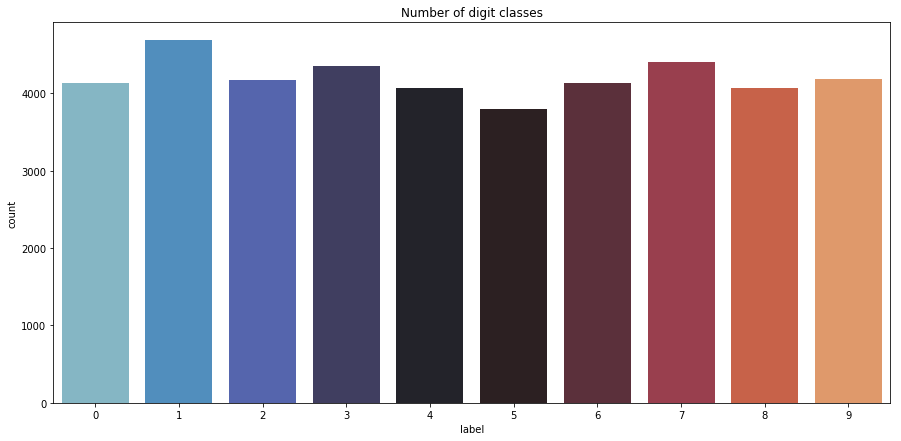

In [6]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

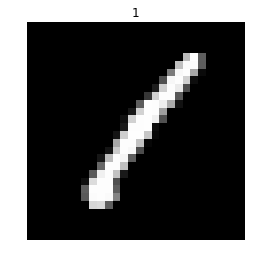

In [7]:
# plot some samples
img = X_train.iloc[0].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

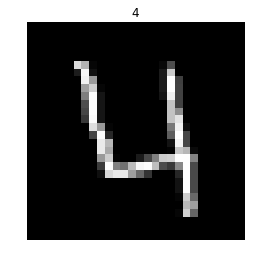

In [8]:
# plot some samples
img = X_train.iloc[3].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

<a id="2"></a>
## Normalization, Reshape and Label Encoding 
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28) 
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [9]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [10]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [11]:
# Label Encoding 
Y_train = one_hot(Y_train, num_classes = 10)

In [12]:

# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
# Y_train = to_categorical(Y_train, num_classes = 10)

<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 10%.
* train size is 90%.

In [13]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


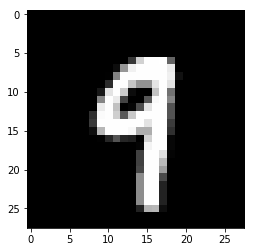

In [14]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="4"></a>
## Convolutional Neural Network 
* CNN is used for image classification, object detection 
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

<a id="5"></a>
### What is Convolution Operation?
* We have some image and feature detector(3*3)
* Feature detector does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* Feature detector = kernel = filter
* Feauture detector detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices.
* feature map = convolved feature
* Stride = navigating in input image.
* We reduce the size of image. This is important bc code runs faster. However, we lost information. 
* We create multiple feature maps bc we use multiple feature detectors(filters).
* Lets look at gimp. Edge detect: [0,10,0],[10,-4,10],[0,10,0]
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>
* After having convolution layer we use ReLU to break up linearity. Increase nonlinearity. Because images are non linear.
* <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

<a id="6"></a>
### Same Padding
* As we keep applying conv layers, the size of the volume will decrease faster than we would like. In the early layers of our network, we want to preserve as much information about the original input volume so that we can extract those low level features.
* input size and output size are same.
* <a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>

<a id="7"></a>
### Max Pooling
* It makes down-sampling or sub-sampling (Reduces the number of parameters)
* It makes the detection of features invariant to scale or orientation changes.
* It reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
* <a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>

<a id="8"></a>
### Flattening
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>

<a id="9"></a>
### Full Connection
* Neurons in a fully connected layer have connections to all activations in the previous layer
* Artificial Neural Network
* <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

<a id="10"></a>
## Implementing with Simple Numpy CNN

<a id="11"></a>
### Create Model
* conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)
* Dropout: Dropout is a technique where randomly selected neurons are ignored during training
* <a href="https://ibb.co/jGcvVU"><img src="https://preview.ibb.co/e7yPPp/dropout.jpg" alt="dropout" border="0"></a>

In [15]:
# Assuming X_train and Y_train are already available
X_train = X_train.reshape(37800, -1)  # Flatten (N, 28, 28) to (N, 784)
# Y_train = one_hot(Y_train, num_classes = 10)      # Make sure Y_train is one-hot encoded

# You must also have a validation set, e.g.:
X_val = X_val.reshape(4200, -1)  # Flatten (N, 28, 28) to (N, 784)
# Y_val = one_hot(Y_val, 10)


In [16]:

dense1 = Dense(784, 128)
relu1 = SimpleReLU()
dense2 = Dense(128, 10)
loss_fn = SimpleSoftmaxLoss()

losses, train_accs = [], []

# Training loop
for epoch in range(100):
    # Forward
    out = dense1.forward(X_train)
    out = relu1.forward(out)
    out = dense2.forward(out)
    loss = loss_fn.forward(out, Y_train)

    # Backward
    grad = loss_fn.backward()
    grad = dense2.simple_backward(grad)
    grad = relu1.backward(grad)
    grad = dense1.simple_backward(grad)

    # Evaluate on training
    train_loss, train_acc = train_evaluate(X_train, Y_train, dense1, relu1, dense2, loss_fn)

    # Optionally, also evaluate on validation if available
    model = [
            dense1,
            relu1,
            dense2,
            loss_fn
        ]
    val_loss, val_acc = valid_evaluate(model, model[-1], X_val, Y_val)

    losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"           Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1 - Loss: 2.3239, Accuracy: 0.1196
           Val Loss: 2.3322, Val Accuracy: 0.1162
Epoch 2 - Loss: 2.3087, Accuracy: 0.1245
           Val Loss: 2.3168, Val Accuracy: 0.1207
Epoch 3 - Loss: 2.2942, Accuracy: 0.1302
           Val Loss: 2.3022, Val Accuracy: 0.1281
Epoch 4 - Loss: 2.2803, Accuracy: 0.1354
           Val Loss: 2.2882, Val Accuracy: 0.1331
Epoch 5 - Loss: 2.2670, Accuracy: 0.1415
           Val Loss: 2.2747, Val Accuracy: 0.1386
Epoch 6 - Loss: 2.2540, Accuracy: 0.1474
           Val Loss: 2.2617, Val Accuracy: 0.1414
Epoch 7 - Loss: 2.2415, Accuracy: 0.1541
           Val Loss: 2.2491, Val Accuracy: 0.1440
Epoch 8 - Loss: 2.2294, Accuracy: 0.1604
           Val Loss: 2.2368, Val Accuracy: 0.1490
Epoch 9 - Loss: 2.2176, Accuracy: 0.1661
           Val Loss: 2.2249, Val Accuracy: 0.1567
Epoch 10 - Loss: 2.2061, Accuracy: 0.1726
           Val Loss: 2.2132, Val Accuracy: 0.1605
Epoch 11 - Loss: 2.1948, Accuracy: 0.1789
           Val Loss: 2.2018, Val Accuracy: 0.16

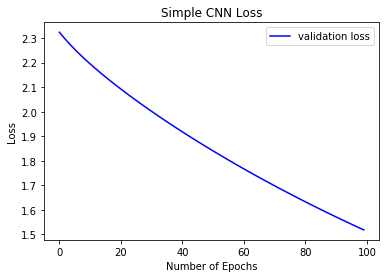

In [17]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(losses, color='b', label="validation loss")
plt.title("Simple CNN Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

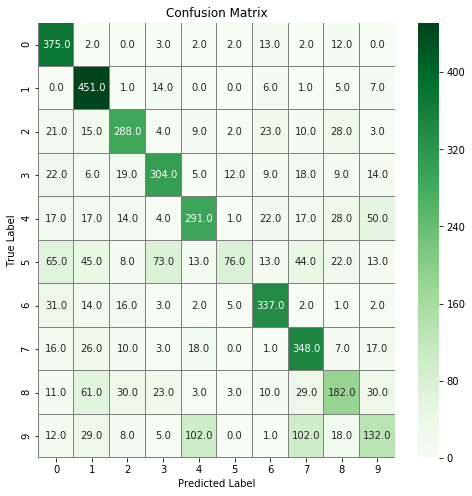

In [18]:
# confusion matrix

# Predict the values from the validation dataset
Y_pred = predict(X_val, dense1, relu1, dense2)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# True and predicted labels
true_labels = []
pred_labels = []
for i in range(10):
    for j in range(10):
        true_labels.extend([i] * int(confusion_mtx[i][j]))
        pred_labels.extend([j] * int(confusion_mtx[i][j]))

# Calculate classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_table = [(label, round(m['precision'], 3), round(m['recall'], 3), round(m['f1-score'], 3)) 
                for label, m in report.items() if label.isdigit()]

simple_df = pd.DataFrame(report_table, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
simple_df

,Class,Precision,Recall,F1-Score
0,0,0.658,0.912,0.765
1,1,0.677,0.930,0.784
2,2,0.731,0.715,0.723
3,3,0.697,0.727,0.712
4,4,0.654,0.631,0.642
5,5,0.752,0.204,0.321
6,6,0.775,0.816,0.795
7,7,0.607,0.780,0.683
8,8,0.583,0.476,0.524
9,9,0.493,0.323,0.390


<a id="10"></a>
## Implementing CNN + Adam Optimization

In [20]:

dense1 = Dense(784, 128)
relu1 = SimpleReLU()
dense2 = Dense(128, 10)
loss_fn = SimpleSoftmaxLoss()

losses, train_accs = [], []

# Training loop
for epoch in range(100):
    # Forward
    out = dense1.forward(X_train)
    out = relu1.forward(out)
    out = dense2.forward(out)
    loss = loss_fn.forward(out, Y_train)

    # Backward
    grad = loss_fn.backward()
    grad = dense2.adam_backward(grad)
    grad = relu1.backward(grad)
    grad = dense1.adam_backward(grad)

    # Evaluate on training
    train_loss, train_acc = train_evaluate(X_train, Y_train, dense1, relu1, dense2, loss_fn)

    # Optionally, also evaluate on validation if available
    model = [
            dense1,
            relu1,
            dense2,
            loss_fn
        ]
    val_loss, val_acc = valid_evaluate(model, model[-1], X_val, Y_val)

    losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"           Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1 - Loss: 1.5936, Accuracy: 0.4095
           Val Loss: 1.6120, Val Accuracy: 0.4069
Epoch 2 - Loss: 1.1527, Accuracy: 0.6426
           Val Loss: 1.1611, Val Accuracy: 0.6295
Epoch 3 - Loss: 0.8798, Accuracy: 0.7406
           Val Loss: 0.8747, Val Accuracy: 0.7400
Epoch 4 - Loss: 0.6584, Accuracy: 0.8012
           Val Loss: 0.6607, Val Accuracy: 0.8017
Epoch 5 - Loss: 0.5401, Accuracy: 0.8277
           Val Loss: 0.5525, Val Accuracy: 0.8231
Epoch 6 - Loss: 0.5309, Accuracy: 0.8338
           Val Loss: 0.5395, Val Accuracy: 0.8226
Epoch 7 - Loss: 0.4877, Accuracy: 0.8497
           Val Loss: 0.4884, Val Accuracy: 0.8464
Epoch 8 - Loss: 0.4275, Accuracy: 0.8694
           Val Loss: 0.4241, Val Accuracy: 0.8710
Epoch 9 - Loss: 0.3975, Accuracy: 0.8797
           Val Loss: 0.3973, Val Accuracy: 0.8807
Epoch 10 - Loss: 0.3988, Accuracy: 0.8803
           Val Loss: 0.4009, Val Accuracy: 0.8790
Epoch 11 - Loss: 0.3995, Accuracy: 0.8804
           Val Loss: 0.4006, Val Accuracy: 0.87

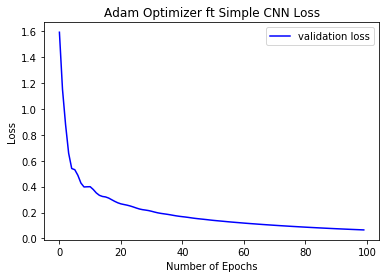

In [21]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(losses, color='b', label="validation loss")
plt.title("Adam Optimizer ft Simple CNN Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

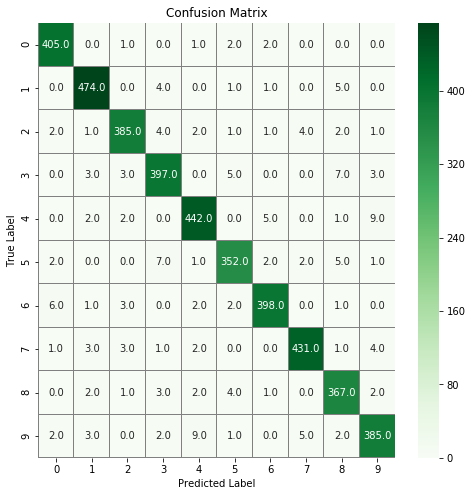

In [22]:
# confusion matrix

# Predict the values from the validation dataset
Y_pred = predict(X_val, dense1, relu1, dense2)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [23]:
# True and predicted labels
true_labels = []
pred_labels = []
for i in range(10):
    for j in range(10):
        true_labels.extend([i] * int(confusion_mtx[i][j]))
        pred_labels.extend([j] * int(confusion_mtx[i][j]))

# Calculate classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_table = [(label, round(m['precision'], 3), round(m['recall'], 3), round(m['f1-score'], 3)) 
                for label, m in report.items() if label.isdigit()]

adam_df = pd.DataFrame(report_table, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
adam_df

,Class,Precision,Recall,F1-Score
0,0,0.969,0.985,0.977
1,1,0.969,0.977,0.973
2,2,0.967,0.955,0.961
3,3,0.950,0.950,0.950
4,4,0.959,0.959,0.959
5,5,0.957,0.946,0.951
6,6,0.971,0.964,0.967
7,7,0.975,0.966,0.971
8,8,0.939,0.961,0.950
9,9,0.951,0.941,0.946


<a id="10"></a>
## Implementing with Simple CNN + Residual Network

In [24]:
class ResidualBlock:
    def __init__(self, size, lr=0.001):
        self.dense1 = Dense(size, size, lr=lr)
        self.relu1 = SimpleReLU()
        self.dense2 = Dense(size, size, lr=lr)
        self.relu2 = SimpleReLU()

    def forward(self, x):
        self.input = x
        out = self.dense1.forward(x)
        out = self.relu1.forward(out)
        out = self.dense2.forward(out)
        out = out + x  # Residual connection
        out = self.relu2.forward(out)
        self.out = out
        return out

    def backward(self, grad_output):
        grad = self.relu2.backward(grad_output)
        grad_residual = grad  # Skip path
        grad = self.dense2.adam_backward(grad)
        grad = self.relu1.backward(grad)
        grad = self.dense1.adam_backward(grad)
        return grad + grad_residual  # Add gradients through residual


In [25]:
# flatten = Flatten()
dense_in = Dense(784, 128, lr=0.001)
relu_in = SimpleReLU()
res_block = ResidualBlock(128, lr=0.001)
dense_out = Dense(128, 10, lr=0.001)
loss_fn = SimpleSoftmaxLoss()
losses, train_accs = [], []

# X_train = X_train.reshape(X_train.shape[0], -1)
# Y_train_oh = one_hot(y_train, 10)

for epoch in range(100):
    # Forward
    # out = flatten.forward(X_train)
    out = dense_in.forward(X_train)
    out = relu_in.forward(out)
    out = res_block.forward(out)
    out = dense_out.forward(out)
    loss = loss_fn.forward(out, Y_train)

    # Backward with Adam
    grad = loss_fn.backward()
    grad = dense_out.adam_backward(grad)
    grad = res_block.backward(grad)
    grad = relu_in.backward(grad)
    grad = dense_in.adam_backward(grad)

    # Evaluate on training
    train_loss, train_acc = train_evaluate(X_train, Y_train, dense_in, relu_in, dense_out, loss_fn)

    # Optionally, also evaluate on validation if available
    model = [
            dense_in, 
            relu_in, 
            dense_out, 
            loss_fn
        ]
    val_loss, val_acc = valid_evaluate(model, model[-1], X_val, Y_val)

    losses.append(train_loss)
    train_accs.append(train_acc)
    print(f"Epoch {epoch + 1} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"           Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1 - Loss: 2.3785, Accuracy: 0.0689
           Val Loss: 2.3924, Val Accuracy: 0.0717
Epoch 2 - Loss: 2.3070, Accuracy: 0.1023
           Val Loss: 2.3236, Val Accuracy: 0.1033
Epoch 3 - Loss: 2.2399, Accuracy: 0.1534
           Val Loss: 2.2589, Val Accuracy: 0.1445
Epoch 4 - Loss: 2.1737, Accuracy: 0.2117
           Val Loss: 2.1941, Val Accuracy: 0.2043
Epoch 5 - Loss: 2.1069, Accuracy: 0.2707
           Val Loss: 2.1277, Val Accuracy: 0.2619
Epoch 6 - Loss: 2.0391, Accuracy: 0.3286
           Val Loss: 2.0601, Val Accuracy: 0.3095
Epoch 7 - Loss: 1.9714, Accuracy: 0.3801
           Val Loss: 1.9920, Val Accuracy: 0.3605
Epoch 8 - Loss: 1.9052, Accuracy: 0.4253
           Val Loss: 1.9253, Val Accuracy: 0.4060
Epoch 9 - Loss: 1.8411, Accuracy: 0.4640
           Val Loss: 1.8608, Val Accuracy: 0.4460
Epoch 10 - Loss: 1.7792, Accuracy: 0.4998
           Val Loss: 1.7987, Val Accuracy: 0.4805
Epoch 11 - Loss: 1.7194, Accuracy: 0.5308
           Val Loss: 1.7388, Val Accuracy: 0.50

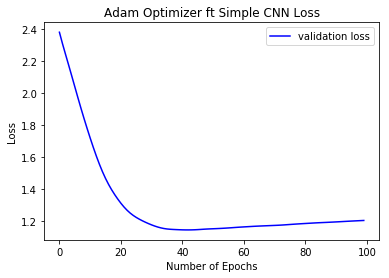

In [26]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(losses, color='b', label="validation loss")
plt.title("Adam Optimizer ft Simple CNN Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

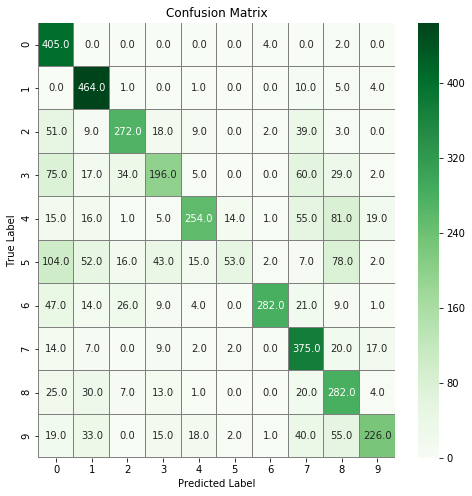

In [27]:
# Predict the values from the validation dataset
Y_pred = predict(X_val, dense_in, relu_in, dense_out)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# True and predicted labels
true_labels = []
pred_labels = []
for i in range(10):
    for j in range(10):
        true_labels.extend([i] * int(confusion_mtx[i][j]))
        pred_labels.extend([j] * int(confusion_mtx[i][j]))

# Calculate classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_table = [(label, round(m['precision'], 3), round(m['recall'], 3), round(m['f1-score'], 3)) 
                for label, m in report.items() if label.isdigit()]

res_df = pd.DataFrame(report_table, columns=['Class', '<ResNet CNN> Precision', '<ResNet CNN> Recall', '<ResNet CNN> F1-Score'])
res_df

,Class,<ResNet CNN> Precision,<ResNet CNN> Recall,<ResNet CNN> F1-Score
0,0,0.536,0.985,0.695
1,1,0.723,0.957,0.823
2,2,0.762,0.675,0.716
3,3,0.636,0.469,0.540
4,4,0.822,0.551,0.660
5,5,0.746,0.142,0.239
6,6,0.966,0.683,0.800
7,7,0.598,0.841,0.699
8,8,0.500,0.738,0.596
9,9,0.822,0.553,0.661


<a id="13"></a>
## Implementing with Keras

In [29]:
# read train 
train = pd.read_csv("../input/train.csv")
# read test 
test= pd.read_csv("../input/test.csv")
# put labels into y_train variable
Y_train = train["label"]
# read test 
test= pd.read_csv("../input/test.csv")
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1)
# put labels into y_train variable
Y_train = train["label"]

In [30]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

Y_train = to_categorical(Y_train, num_classes = 10)



x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [31]:
# 
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

<a id="13"></a>
### Compile Model
* categorical crossentropy
* We make binary cross entropy at previous parts and in machine learning tutorial
* At this time we use categorical crossentropy. That means that we have multi class.
* <a href="https://ibb.co/jm1bpp"><img src="https://preview.ibb.co/nN3ZaU/cce.jpg" alt="cce" border="0"></a>


In [32]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [33]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<a id="14"></a>
### Epochs and Batch Size
* Say you have a dataset of 10 examples (or samples). You have a **batch size** of 2, and you've specified you want the algorithm to run for 3 **epochs**. Therefore, in each epoch, you have 5 **batches** (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations **per epoch**.
* reference: https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [34]:
epochs = 10  # for better result increase the epochs
batch_size = 250

<a id="15"></a>
### Data Augmentation
* To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
* Alter the training data with small transformations to reproduce the variations of digit.
* For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.
* <a href="https://ibb.co/k24CUp"><img src="https://preview.ibb.co/nMxXUp/augment.jpg" alt="augment" border="0"></a>
    


In [35]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (42000, 784)

In [ ]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

In [ ]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<a id="13"></a>
### Comparing Results

In [ ]:
# True and predicted labels
true_labels = []
pred_labels = []
for i in range(10):
    for j in range(10):
        true_labels.extend([i] * int(confusion_mtx[i][j]))
        pred_labels.extend([j] * int(confusion_mtx[i][j]))

# Calculate classification report
report = classification_report(true_labels, pred_labels, output_dict=True)
report_table = [(label, round(m['precision'], 3), round(m['recall'], 3), round(m['f1-score'], 3)) 
                for label, m in report.items() if label.isdigit()]

keras_df = pd.DataFrame(report_table, columns=['Class', '<Keras CNN> Precision', '<Keras CNN> Recall', '<Keras CNN> F1-Score'])
keras_df

In [ ]:
simple_df = simple_df.rename({'Precision': '<Simple> Precision', 
                              'Recall': '<Simple> Recall', 
                              'F1-Score': '<Simple> F1-Score'}, axis=1)

adam_df = adam_df.rename({'Precision': '<Adam> Precision', 
                              'Recall': '<Adam> Recall', 
                              'F1-Score': '<Adam> F1-Score'}, axis=1)

# res_df = res_df.rename({'Precision': '<Res+Adam> Precision', 
#                               'Recall': '<Res+Adam> Recall', 
#                               'F1-Score': '<Res+Adam> F1-Score'}, axis=1)




In [ ]:
score_df = simple_df.merge(adam_df, how='left', on='Class')\
                    .merge(res_df, how='left', on='Class')\
                    .merge(keras_df, how='left', on='Class')\

score_df

<a id="18"></a>
## Conclusion
* http://scs.ryerson.ca/~aharley/vis/conv/flat.html
* HW
* If you have any question I will be very happy to hear it.

<a id="18"></a>
## Implementing with Numpy CNN Conv2D

In [ ]:
# # Activation functions
# def relu(x): return np.maximum(0, x)
# def relu_deriv(x): return (x > 0).astype(float)

# def softmax(x):
#     x -= np.max(x, axis=1, keepdims=True)
#     e_x = np.exp(x)
#     return e_x / np.sum(e_x, axis=1, keepdims=True)

# def cross_entropy(predictions, targets):
#     N = predictions.shape[0]
#     return -np.sum(targets * np.log(predictions + 1e-8)) / N

# def one_hot(y, num_classes):
#     return np.eye(num_classes)[y]


# class SimpleReLU:
#     def forward(self, x):
#         self.x = x
#         return relu(x)

#     def backward(self, grad_output):
#         return grad_output * relu_deriv(self.x)

# class SimpleSoftmaxLoss:
#     def forward(self, x, y):
#         self.y = y
#         self.out = softmax(x)
#         return cross_entropy(self.out, y)

#     def backward(self):
#         return (self.out - self.y) / self.y.shape[0]


# class Flatten:
#     def forward(self, x):
#         self.x_shape = x.shape
#         return x.reshape(x.shape[0], -1)

#     def backward(self, grad_output):
#         return grad_output.reshape(self.x_shape)
# # Re-import model components needed after reset

# class Conv2D_im2col:
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, lr=0.001):
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.kernel_size = kernel_size
#         self.stride = stride
#         self.padding = padding
#         self.lr = lr
#         self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2. / (in_channels * kernel_size * kernel_size))
#         self.biases = np.zeros(out_channels)

#     def im2col(self, x):
#         N, C, H, W = x.shape
#         KH, KW = self.kernel_size, self.kernel_size
#         OH = (H + 2 * self.padding - KH) // self.stride + 1
#         OW = (W + 2 * self.padding - KW) // self.stride + 1
#         img = np.pad(x, [(0,0), (0,0), (self.padding,self.padding), (self.padding,self.padding)], mode='constant')
#         cols = np.zeros((N, C, KH, KW, OH, OW))
#         for y in range(KH):
#             y_max = y + self.stride * OH
#             for x_ in range(KW):
#                 x_max = x_ + self.stride * OW
#                 cols[:, :, y, x_, :, :] = img[:, :, y:y_max:self.stride, x_:x_max:self.stride]
#         cols = cols.transpose(0, 4, 5, 1, 2, 3).reshape(N * OH * OW, -1)
#         return cols, OH, OW

#     def col2im(self, dcol, x_shape, OH, OW):
#         N, C, H, W = x_shape
#         KH, KW = self.kernel_size, self.kernel_size
#         img = np.zeros((N, C, H + 2*self.padding + self.stride - 1, W + 2*self.padding + self.stride - 1))
#         col = dcol.reshape(N, OH, OW, C, KH, KW).transpose(0, 3, 4, 5, 1, 2)
#         for y in range(KH):
#             y_max = y + self.stride * OH
#             for x_ in range(KW):
#                 x_max = x_ + self.stride * OW
#                 img[:, :, y:y_max:self.stride, x_:x_max:self.stride] += col[:, :, y, x_, :, :]
#         return img[:, :, self.padding:H + self.padding, self.padding:W + self.padding]

#     def forward(self, x):
#         self.x = x
#         self.N, self.C, self.H, self.W = x.shape
#         self.cols, self.OH, self.OW = self.im2col(x)
#         W_col = self.weights.reshape(self.out_channels, -1)
#         out = np.dot(self.cols, W_col.T) + self.biases
#         out = out.reshape(self.N, self.OH, self.OW, self.out_channels).transpose(0, 3, 1, 2)
#         return out

#     def backward(self, dout):
#         dout_flat = dout.transpose(0, 2, 3, 1).reshape(-1, self.out_channels)
#         W_col = self.weights.reshape(self.out_channels, -1)
#         dW = np.dot(dout_flat.T, self.cols).reshape(self.weights.shape)
#         db = np.sum(dout_flat, axis=0)
#         dcol = np.dot(dout_flat, W_col)
#         dx = self.col2im(dcol, self.x.shape, self.OH, self.OW)
#         self.weights -= self.lr * dW
#         self.biases -= self.lr * db
#         return dx

# class MaxPool2x2:
#     def forward(self, x):
#         self.x = x
#         N, C, H, W = x.shape
#         self.out = np.zeros((N, C, H // 2, W // 2))
#         self.mask = np.zeros_like(x)
#         for n in range(N):
#             for c in range(C):
#                 for h in range(0, H, 2):
#                     for w in range(0, W, 2):
#                         window = x[n, c, h:h+2, w:w+2]
#                         max_val = np.max(window)
#                         self.out[n, c, h//2, w//2] = max_val
#                         max_idx = np.unravel_index(np.argmax(window), (2,2))
#                         self.mask[n, c, h + max_idx[0], w + max_idx[1]] = 1
#         return self.out

#     def backward(self, grad_output):
#         dx = np.zeros_like(self.x)
#         N, C, H, W = self.out.shape
#         for n in range(N):
#             for c in range(C):
#                 for h in range(H):
#                     for w in range(W):
#                         h_start, w_start = h*2, w*2
#                         dx[n, c, h_start:h_start+2, w_start:w_start+2] += grad_output[n, c, h, w] * self.mask[n, c, h_start:h_start+2, w_start:w_start+2]
#         return dx

# class Dense:
#     def __init__(self, in_features, out_features, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
#         self.w = np.random.randn(in_features, out_features) * np.sqrt(2. / in_features)
#         self.b = np.zeros(out_features)
#         self.lr = lr
#         self.beta1 = beta1
#         self.beta2 = beta2
#         self.epsilon = epsilon
#         self.t = 0
#         self.m_w = np.zeros_like(self.w)
#         self.v_w = np.zeros_like(self.w)
#         self.m_b = np.zeros_like(self.b)
#         self.v_b = np.zeros_like(self.b)

#     def forward(self, x):
#         self.x = x
#         return x @ self.w + self.b

#     def backward(self, grad_output):
#         grad_w = self.x.T @ grad_output
#         grad_b = np.sum(grad_output, axis=0)
#         grad_input = grad_output @ self.w.T
#         self.t += 1
#         self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * grad_w
#         self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (grad_w ** 2)
#         m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
#         v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
#         self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * grad_b
#         self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (grad_b ** 2)
#         m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
#         v_b_hat = self.v_b / (1 - self.beta2 ** self.t)
#         self.w -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
#         self.b -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
#         return grad_input

# class SimpleCNN2D:
#     def __init__(self):
#         self.conv = Conv2D_im2col(1, 8, 3, stride=1, padding=1, lr=0.001)
#         self.relu1 = SimpleReLU()
#         self.pool = MaxPool2x2()
#         self.flatten = Flatten()
#         self.fc = Dense(8 * 14 * 14, 10, lr=0.001)
#         self.loss_fn = SimpleSoftmaxLoss()

#     def forward(self, x, y):
#         out = self.conv.forward(x)
#         out = self.relu1.forward(out)
#         out = self.pool.forward(out)
#         out = self.flatten.forward(out)
#         out = self.fc.forward(out)
#         loss = self.loss_fn.forward(out, y)
#         return loss

#     def backward(self):
#         grad = self.loss_fn.backward()
#         grad = self.fc.backward(grad)
#         grad = self.flatten.backward(grad)
#         grad = self.pool.backward(grad)
#         grad = self.relu1.backward(grad)
#         grad = self.conv.backward(grad)

#     def predict(self, x):
#         out = self.conv.forward(x)
#         out = self.relu1.forward(out)
#         out = self.pool.forward(out)
#         out = self.flatten.forward(out)
#         out = self.fc.forward(out)
#         probs = softmax(out)
#         return np.argmax(probs, axis=1)


In [ ]:
# # read train 
# train = pd.read_csv("../input/train.csv")
# train = train[:1000]
# print(train.shape)
# train.head()


# # read test 
# test= pd.read_csv("../input/test.csv")
# test = test[:1000]
# print(test.shape)
# test.head()


# # put labels into y_train variable
# Y_train = train["label"]
# # Drop 'label' column
# X_train = train.drop(labels = ["label"],axis = 1) 


# # Normalize the data
# X_train = X_train / 255.0
# test = test / 255.0
# print("x_train shape: ",X_train.shape)
# print("test shape: ",test.shape)


# # Reshape
# X_train = X_train.values.reshape(-1, 1, 28, 28)#(-1,28,28,1)
# test = test.values.reshape(-1, 1, 28, 28)#(-1,28,28,1)

# print("x_train shape: ",X_train.shape)
# print("test shape: ",test.shape)

# # Label Encoding 

# Y_train = one_hot(Y_train, num_classes = 10)


# # Split the train and the validation set for the fitting
# from sklearn.model_selection import train_test_split
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
# print("x_train shape",X_train.shape)
# print("x_test shape",X_val.shape)
# print("y_train shape",Y_train.shape)
# print("y_test shape",Y_val.shape)

In [ ]:
# # Start training loop on the real sample data

# model = SimpleCNN2D()
# train_losses, val_losses = [], []

# for epoch in range(10):
#     loss = model.forward(X_train, Y_train)
#     model.backward()

#     train_pred = model.predict(X_train)
#     train_labels = np.argmax(Y_train, axis=1)
#     train_acc = np.mean(train_pred == train_labels)

#     val_pred = model.predict(X_val)
#     val_labels = np.argmax(Y_val, axis=1)
#     val_acc = np.mean(val_pred == val_labels)
#     val_loss = model.forward(X_val, Y_val)

#     train_losses.append(loss)
#     val_losses.append(val_loss)

#     print(f"Epoch {epoch+1}: Train Loss={loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")
